In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from datetime import date
from sklearn.metrics import mean_absolute_percentage_error
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('VNM Historical Data.csv')

In [3]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [4]:
df = df[['Price']]
df

,Price
0,159039.0
1,164719.0
2,161473.0
3,158227.0
4,150924.0
...,...
1509,67000.0
1510,67000.0
1511,68100.0
1512,67800.0


In [5]:
df['Target'] = df.Price.shift(-1)
df.dropna(inplace = True)
df.head()

,Price,Target
0,159039.0,164719.0
1,164719.0,161473.0
2,161473.0,158227.0
3,158227.0,150924.0
4,150924.0,152628.0


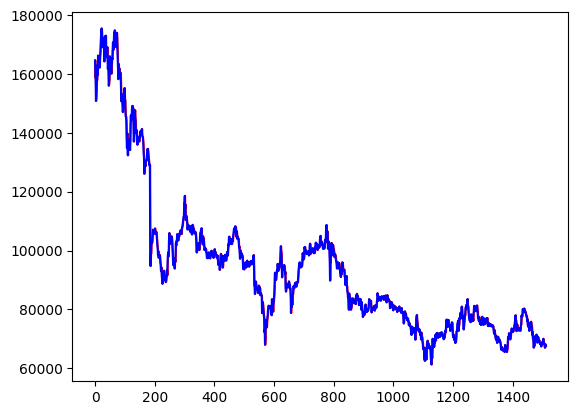

In [6]:
# gán biến
X = df[['Price']]
y = df[['Target']] # các biến độc lập

plt.plot(X, color = 'r')
plt.plot(y, color = 'b')
plt.show()

In [7]:
# chia train, test
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

In [8]:
# tạo mô hình SVR
svr_rbf = SVR(kernel='rbf', C=1000)
svr_rbf.fit(X_train, y_train)

svr_poly = SVR(kernel='poly', C=1000, degree = 2)
svr_poly.fit(X_train, y_train)

SVR(C=1000, degree=2, kernel='poly')

In [9]:
# dự đoán giá đóng cửa trên tập kiểm tra
y_pred_rbf = svr_rbf.predict(X_test)
y_pred_rbf = y_pred_rbf.reshape(-1,1)

y_pred_poly = svr_poly.predict(X_test)
y_pred_poly = y_pred_poly.reshape(-1,1)


In [10]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction)

In [11]:
# Calculate MDA for RBF
mda_rbf = calculate_mda(y_test.values.flatten(), y_pred_rbf.flatten())

# Calculate MDA for Poly
mda_poly = calculate_mda(y_test.values.flatten(), y_pred_poly.flatten())



In [12]:
# tính toán độ chính xác của mô hình
mape_rbf = mean_absolute_percentage_error(y_test, y_pred_rbf) * 100
mae_rbf = mean_absolute_error(y_test, y_pred_rbf)
test_rmse_rbf = np.sqrt(np.mean((y_pred_rbf - y_test)**2))

mape_poly = mean_absolute_percentage_error(y_test, y_pred_poly) * 100
mae_poly = mean_absolute_error(y_test, y_pred_poly)
test_rmse_poly = np.sqrt(np.mean((y_pred_poly - y_test)**2))

In [13]:
# in kết quả độ chính xác của mô hình
print("RBF MAPE:", mape_rbf)
print("RBF Testing RMSE:", test_rmse_rbf)

print("Poly MAPE:", mape_poly)
print("Poly Testing RMSE:", test_rmse_poly)


# Print MDA results
print("RBF MDA:", mda_rbf)
print("Poly MDA:", mda_poly)



RBF MAPE: 1.751846508442069
RBF Testing RMSE: 1654.4330219680533
Poly MAPE: 5.7052677290919664
Poly Testing RMSE: 4444.9168009567875
RBF MDA: 0.423841059602649
Poly MDA: 0.4205298013245033


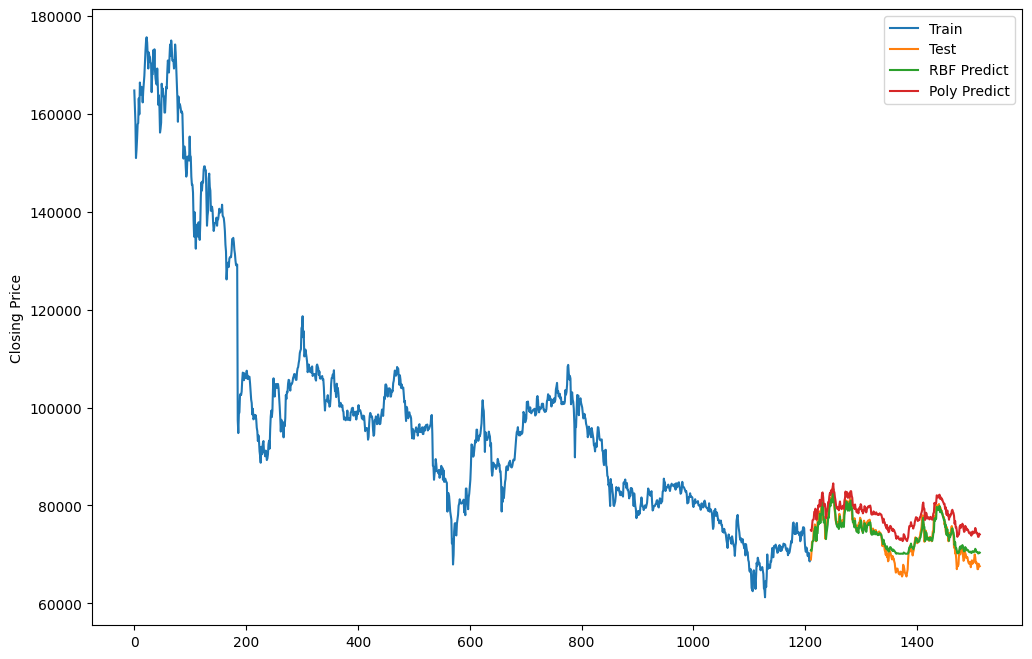

In [14]:
#vẽ mô hình
plt.figure(figsize=(12, 8))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred_rbf, label='RBF Predict')
plt.plot(X_test.index, y_pred_poly, label='Poly Predict')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [15]:
# lấy giá trị Close của ngày cuối cùng trong dataset
last_row = df.tail(1)
last_data = last_row['Price'].values.reshape(-1,1)
last_data

array([[67800.]])

In [16]:
# tạo mảng chứa giá trị predict của 60 ngày tiếp theo
x_next_60_days_rbf = []
x_next_60_days_poly = []
# predict giá Close 60 ngày tiếp theo dựa vào giá Close của ngày trước đó
for i in range(60):
    x_pred_next = svr_rbf.predict(last_data)
    x_next_60_days_rbf.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

for i in range(60):
    x_pred_next = svr_rbf.predict(last_data)
    x_next_60_days_poly.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

print("Kết quả dự đoán sử dụng RBF:", x_next_60_days_rbf)
print("Kết quả dự đoán sử dụng Poly:", x_next_60_days_poly)

Kết quả dự đoán sử dụng RBF: [array([70371.8353]), array([71336.56559568]), array([71873.56061671]), array([72209.82192395]), array([72433.25897742]), array([72587.01831935]), array([72695.22370819]), array([72772.52219664]), array([72828.31694838]), array([72868.88537871]), array([72898.53718961]), array([72920.29183491]), array([72936.29639674]), array([72948.09433505]), array([72956.80411439]), array([72963.24103359]), array([72968.00200231]), array([72971.52545381]), array([72974.13419044]), array([72976.06630085]), array([72977.49762197]), array([72978.55814182]), array([72979.34402363]), array([72979.92644554]), array([72980.35811298]), array([72980.67806433]), array([72980.9152212]), array([72981.09101362]), array([72981.22132248]), array([72981.3179175]), array([72981.38952206]), array([72981.44260201]), array([72981.48195004]), array([72981.51111879]), array([72981.53274169]), array([72981.54877088]), array([72981.56065343]), array([72981.56946207]), array([72981.57599199]), a

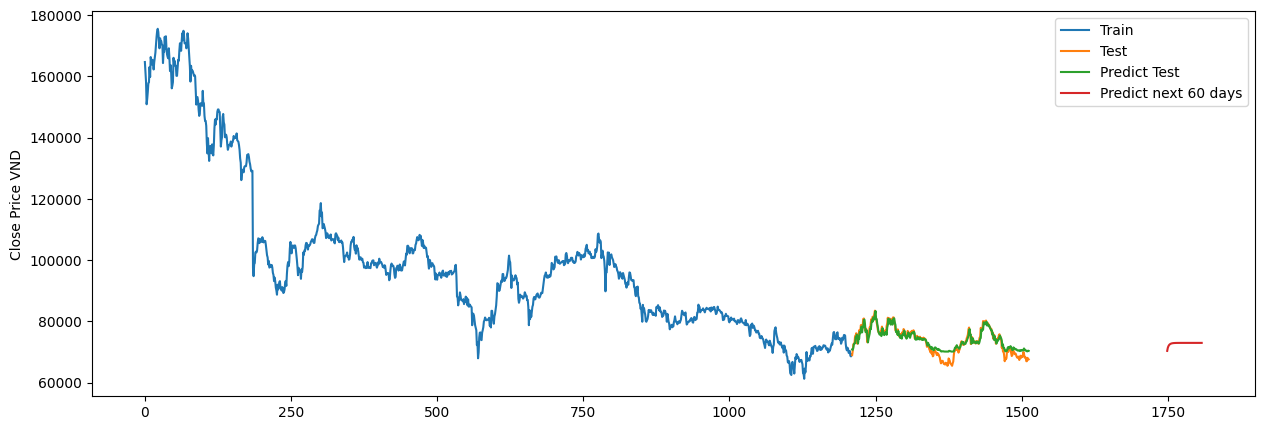

In [17]:
#vẽ mô hình
plt.figure(figsize=(15, 5))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred_rbf, label='Predict Test')


last_date = pd.to_datetime(X_test.index[1])  # Convert last index to datetime

next_dates = np.arange(1749, 1809)

plt.plot(next_dates, x_next_60_days_rbf, label='Predict next 60 days')


plt.ylabel('Close Price VND')

plt.legend()
plt.show()

